In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA

## Fonction utilisé lors de l'analyse exploratoire 

In [77]:

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return output_data
 


In [95]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

In [5]:

def visualisation_acp(spectres, filtre, numero_composante_axe1, numero_composante_axe2):
    """
    Effectue une Analyse en Composantes Principales (ACP) sur les spectres et réalise une visualisation.

    Args:
    spectres (numpy.ndarray): Un tableau NumPy où les lignes représentent les spectres et les colonnes représentent les longueurs d'ondes.
    filtre (numpy.ndarray): Un tableau NumPy contenant les valeurs du filtre pour colorier les points.
    numero_composante_axe1 (int): Le numéro de la composante principale à afficher sur l'axe x.
    numero_composante_axe2 (int): Le numéro de la composante principale à afficher sur l'axe y.

    Returns:
    None
    """
    # Réalisez l'ACP sur les spectres
    pca = PCA()
    resultats_acp = pca.fit_transform(spectres)

    # Créez un scatter plot des résultats de l'ACP en utilisant le filtre pour colorier les points
    plt.figure(figsize=(8, 6))

    classes_uniques = np.unique(filtre)
    couleurs = plt.cm.rainbow(np.linspace(0, 1, len(classes_uniques)))

    for i, classe in enumerate(classes_uniques):
        indices = np.where(filtre == classe)
        plt.scatter(resultats_acp[indices, numero_composante_axe1], resultats_acp[indices, numero_composante_axe2], label=classe, color=couleurs[i])

    plt.xlabel(f'Composante Principale {numero_composante_axe1 + 1}')
    plt.ylabel(f'Composante Principale {numero_composante_axe2 + 1}')
    plt.title(f'ACP des Spectres (CP{numero_composante_axe1 + 1} vs. CP{numero_composante_axe2 + 1})')

    # Affichez la variance expliquée par les composantes
    variance_explicite = pca.explained_variance_ratio_
    plt.figtext(0.15, 0.82, f'Variance expliquée CP{numero_composante_axe1 + 1}: {variance_explicite[numero_composante_axe1]:.2f}', fontsize=10, color='red')
    plt.figtext(0.15, 0.78, f'Variance expliquée CP{numero_composante_axe2 + 1}: {variance_explicite[numero_composante_axe2]:.2f}', fontsize=10, color='blue')

    # Affichez la légende en dehors du graphique
    plt.legend(title='Filtre', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()




But du projet : utiliser les spectres NIR (proche infrarouge) pour :
- différencier les fumiers (classification)
- prédire les concentrations des différents composants chimiques (quantification) 

# Analyse Exploratoire 

Cette analyse exploratoire vise à avoir une vue d’ensemble des différents ensembles de données :
- chemical analysis qui contient les différentes concentrations de composants chimiques des différents fumiers
- les deux jeux de données de spectres (spectra_DG or spectra_FH)
plein de questions auxquelles nous allons essayer de répondre
- concernant l'analyse chimique :
     - la concentration en composant chimique permet-elle de différencier les fumiers ? (facultatif)
- concernant les spectres :
     - y a-t-il des différences entre les différents spectres ? (car les spectres ont été acquis par un autre laboratoire)
     - les spectres permettent-ils de différencier le fumier séché du fumier frais ? si cela est vrai, quel type de spectres permet de différencier les différents fumiers ?

##  1-Analyse exploratoire sur le fichiers chemical analysis

In [6]:
#import dataset chemical
df = pd.read_excel('data/chemical_analysis.xlsx')
df_chemical = df.copy()
df_chemical.head()

,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5,type_manure,spectrometer,township,country
0,FBCRIF001,20.815,0.075,0.490,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,DERVAL,mainland France
1,FBCRIF002,25.480,0.182,0.607,0.157,0.791,0.079,0.131,cattle manure,NIRFlex LDAR,DERVAL,mainland France
2,FBCRIF003,17.595,0.203,0.546,0.208,0.690,0.094,0.160,cattle manure,NIRFlex LDAR,DERVAL,mainland France
3,FBCRIF004,19.110,0.091,0.482,0.260,0.542,0.121,0.187,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France
4,FBCRIF005,18.600,0.089,0.458,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France


In [7]:
df_chemical.columns

Index(['sample_name', 'DM', 'NH4', 'N', 'CaO', 'K2O', 'MgO', 'P2O5',
       'type_manure', 'spectrometer', 'township', 'country'],
      dtype='object')

In [8]:
df_chemical.dtypes

sample_name      object
DM              float64
NH4             float64
N               float64
CaO             float64
K2O             float64
MgO             float64
P2O5            float64
type_manure      object
spectrometer     object
township         object
country          object
dtype: object

In [9]:
df_chemical.isna()

,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5,type_manure,spectrometer,township,country
0,False,False,False,False,True,True,True,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
327,False,False,False,False,True,True,True,True,False,False,False,False
328,False,False,False,False,True,True,True,True,False,False,False,False
329,False,False,False,False,True,True,True,True,False,False,False,False
330,False,False,False,False,True,True,True,True,False,False,False,False


Observation:
- le dataset est incomplet
- il existe deux types de variables : 
    - variables quantitatives : 7
    - variables qualitatives : 5
Pour la suite on va s'interresser aux variables qualitatives pour avoir des informations rapidement 

### 1-1 variables qualitatives



In [10]:
df_chemical.head()

,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5,type_manure,spectrometer,township,country
0,FBCRIF001,20.815,0.075,0.490,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,DERVAL,mainland France
1,FBCRIF002,25.480,0.182,0.607,0.157,0.791,0.079,0.131,cattle manure,NIRFlex LDAR,DERVAL,mainland France
2,FBCRIF003,17.595,0.203,0.546,0.208,0.690,0.094,0.160,cattle manure,NIRFlex LDAR,DERVAL,mainland France
3,FBCRIF004,19.110,0.091,0.482,0.260,0.542,0.121,0.187,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France
4,FBCRIF005,18.600,0.089,0.458,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France


In [11]:
df_chemical_quali = df_chemical.select_dtypes(include=['object'])
df_chemical_quali.head()
df_chemical_quali.columns

Index(['sample_name', 'type_manure', 'spectrometer', 'township', 'country'], dtype='object')

In [12]:
df_chemical_quali = df_chemical_quali.drop('sample_name', axis = 1)
for colonne in df_chemical_quali.columns:
    valeurs_uniques = df_chemical_quali[colonne].unique()
    print(f"Colonne '{colonne}': {valeurs_uniques}")
    

Colonne 'type_manure': ['cattle manure' 'poultry manure']
Colonne 'spectrometer': ['NIRFlex LDAR' 'XDS FOSS ARVALIS' 'XDS FOSS CIRAD']
Colonne 'township': ['DERVAL' 'CHATEAUNEUF DU FAOU' "THORIGNE D'ANJOU" 'MONTREUIL SUR LOIRE'
 'LE RHEU' 'GROUGIS' 'DRAVEGNY' 'PLOUMAGAOR' 'PLOUFRAGAN' 'SAINT PEVER'
 'PLAINE-HAUTE' 'BOURBRIAC' 'SAINT DOWAN' 'CAODOUT' 'PLUSQUELLEC'
 'SAINT NICOLAS DU PELEM' 'SION LES MINES' 'MARTIGUE SUR MAYENNE'
 "PLOEUC L'HERMITAGE" 'COEX' 'SAINT HILAIRE DE LOULOY'
 'LE CHAMP SUR LAYOU' 'LANRIVAIN' 'PLOUNEVEZ-QUINTIN' 'PLOUAGAT'
 'SAINT DONAN' 'MONTOLDRE' 'MOULINS' 'CRECHY' 'LANRODEC' 'BEGARD'
 'LE FOEIL' 'MOHAN' 'LANTILLAC' 'BIGNAN' 'MOHON' 'MOREAC'
 'SAINT HILAIRE LES LOGES' 'FARSSAIS-PAYE' 'RADENAC' 'PLELO'
 'PLEUMEUR-BODOU' 'CALLAC' 'PLOSQUELLEC' 'LANFAINS' 'PLOERMEL' 'PENGUILY'
 'SAINT CARREUC' 'INGRANNES' 'VIEILLES-MAISONS' 'LORRIS'
 'CHILLEURS AUX BOIS' 'CHATEAUNEUF SUR LOIRE' 'OUJOUET SUR TRAYE' 'CIGNE'
 'GUEHENNO' 'BREST' 'LE MOUSTOIR' 'PLENNE-JUGNON' 'SAINT T

#### Conclusion
Pour la suite on gardera les variables :  'type_manure', 'spectrometer', 'country'

### 1-2 Variables quantitatives

In [13]:
df_chemical_quanti = df_chemical.drop(df_chemical.iloc[:, 8:12], axis= 1)
df_chemical_quanti

,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5
0,FBCRIF001,20.815,0.075,0.490,NaN,NaN,NaN,NaN
1,FBCRIF002,25.480,0.182,0.607,0.157,0.791,0.079,0.131
2,FBCRIF003,17.595,0.203,0.546,0.208,0.690,0.094,0.160
3,FBCRIF004,19.110,0.091,0.482,0.260,0.542,0.121,0.187
4,FBCRIF005,18.600,0.089,0.458,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
327,R_FERM_48_FBV_LT,37.350,0.052,0.632,NaN,NaN,NaN,NaN
328,R_FERM_49_FBV_LT,34.340,0.045,0.432,NaN,NaN,NaN,NaN
329,R_FERM_50_FBV_LT,25.690,0.068,0.536,NaN,NaN,NaN,NaN
330,R_FERM_69_FBV,30.660,0.154,0.642,NaN,NaN,NaN,NaN


#### Visualisation dans un scatterplot 
- visualisation des données qualitatives dans des scatter plot
- visualisation en fonction des données qualitatives : manure et country


visualisation des données quantitative dans des scatter plot et matrice de corrélations

In [14]:
df_chemical_quanti.head()


,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5
0,FBCRIF001,20.815,0.075,0.490,NaN,NaN,NaN,NaN
1,FBCRIF002,25.480,0.182,0.607,0.157,0.791,0.079,0.131
2,FBCRIF003,17.595,0.203,0.546,0.208,0.690,0.094,0.160
3,FBCRIF004,19.110,0.091,0.482,0.260,0.542,0.121,0.187
4,FBCRIF005,18.600,0.089,0.458,NaN,NaN,NaN,NaN


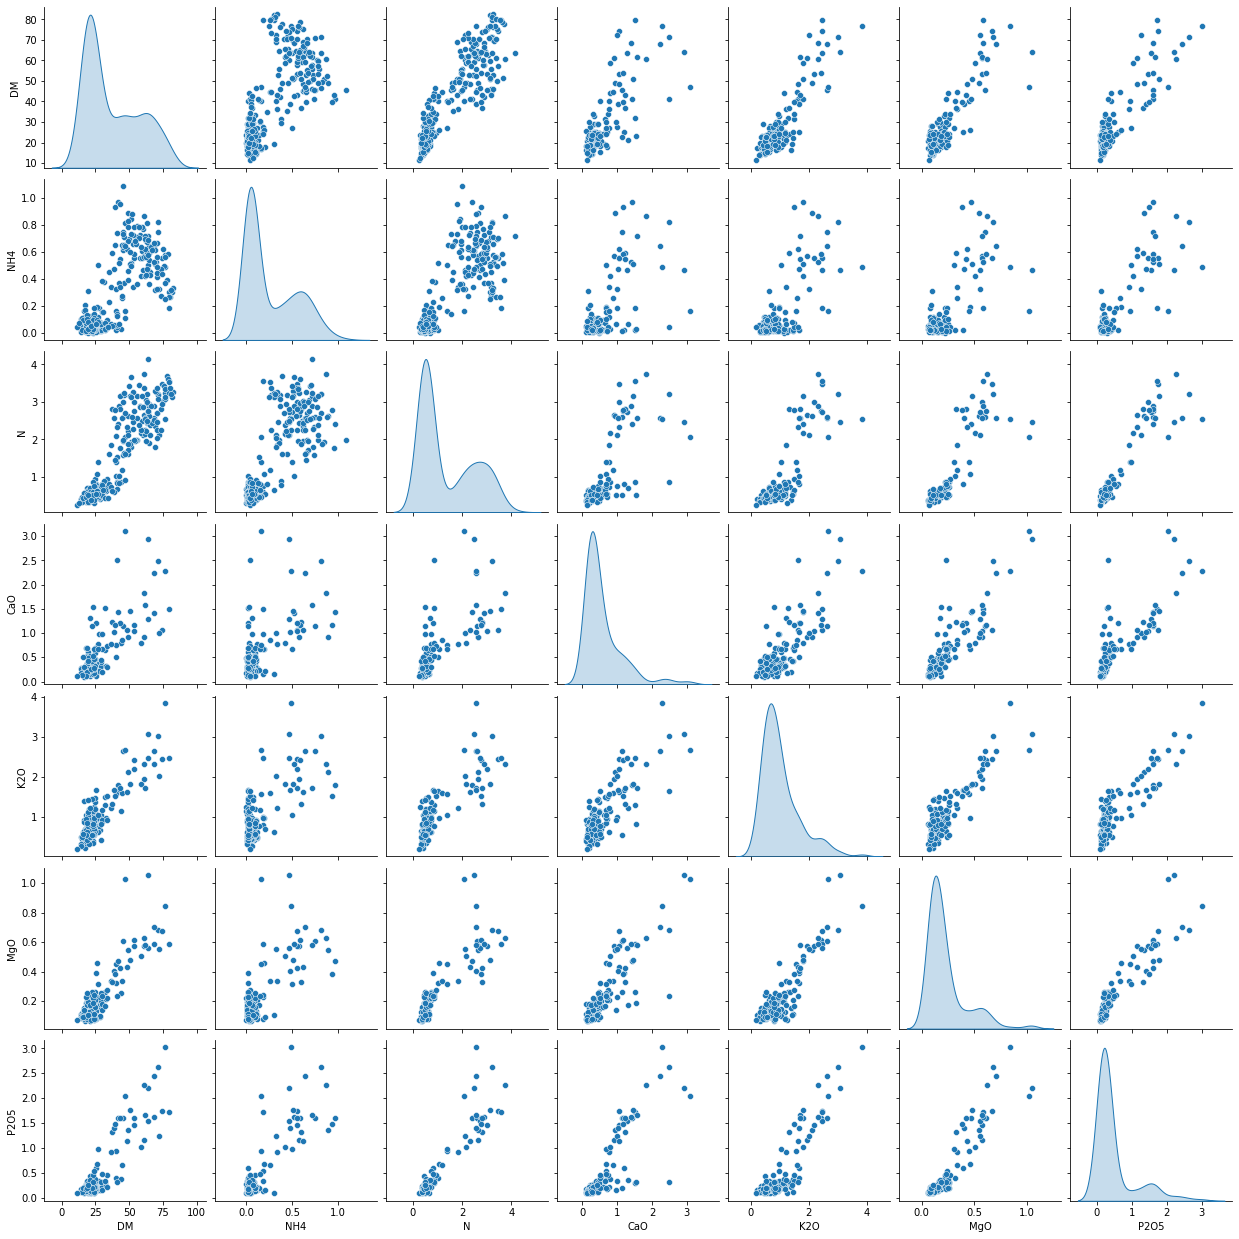

In [15]:
sns.pairplot(df_chemical_quanti,diag_kind="kde")

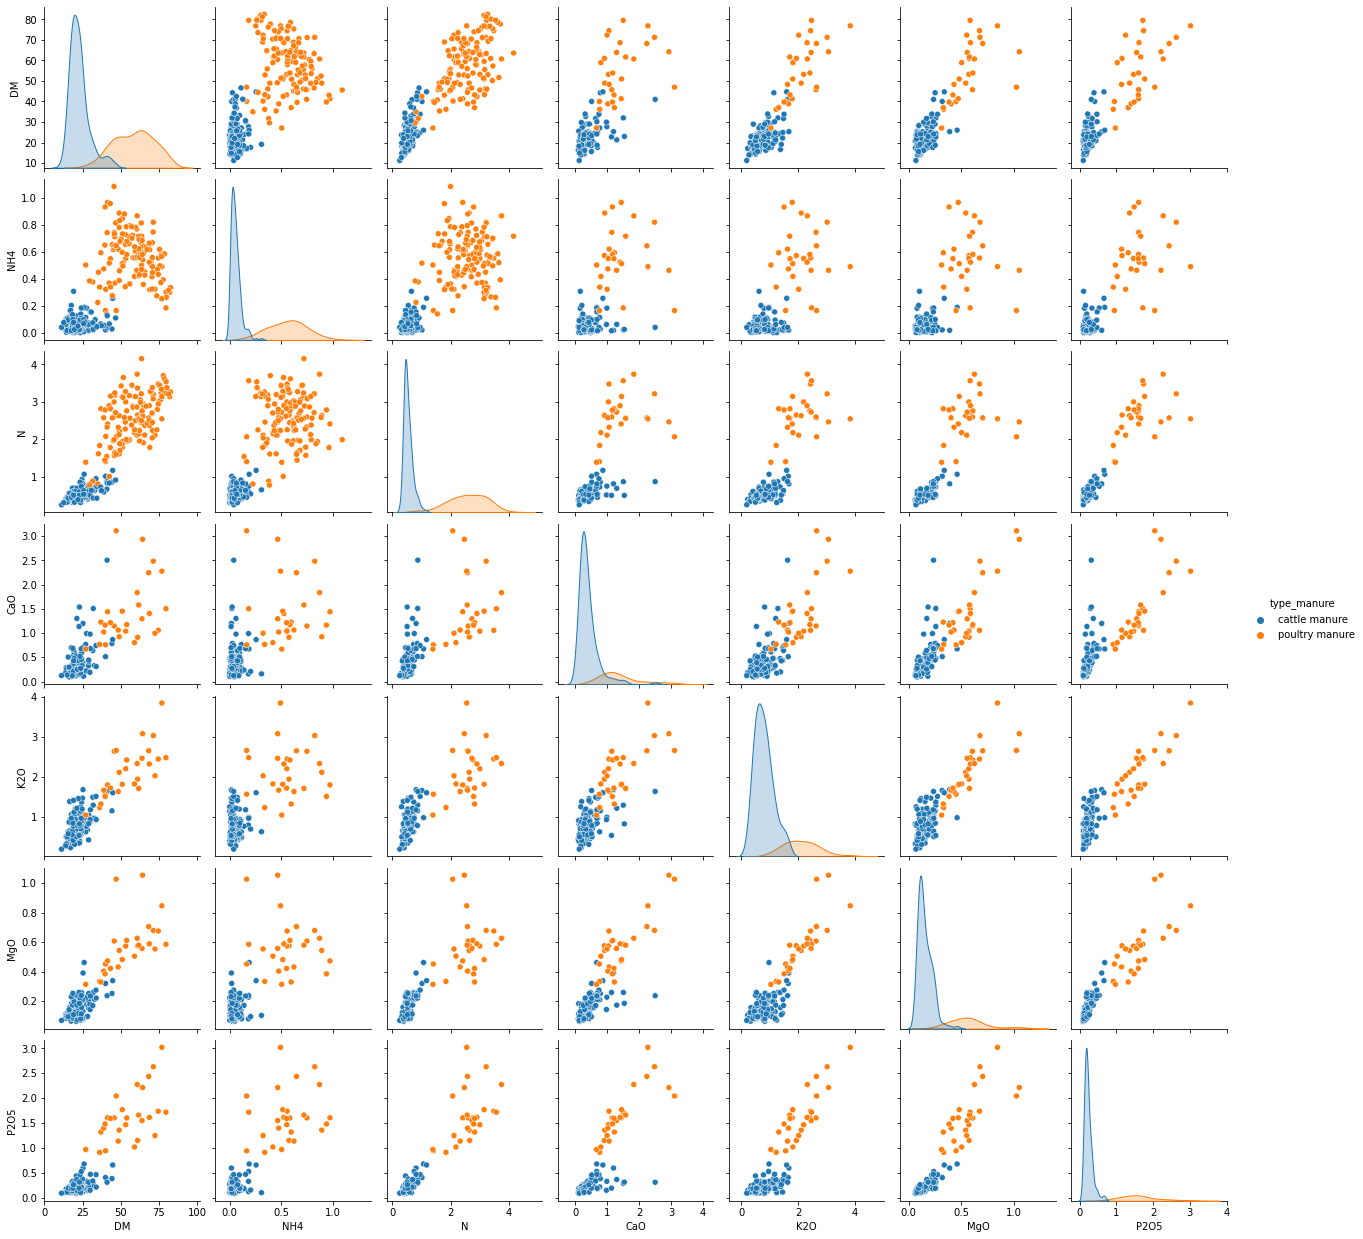

In [16]:
sns.pairplot(df_chemical, diag_kind = "kde", hue = "type_manure")

##### infos graphique précédent
différence entre les données chimiques en fonction du types de fumiers (manure)
- cattle_manure : données chimiques faibles 
- poultry_manure : données chimiques reparties un peu plus mais dans la majorité des cas les données sont élévées


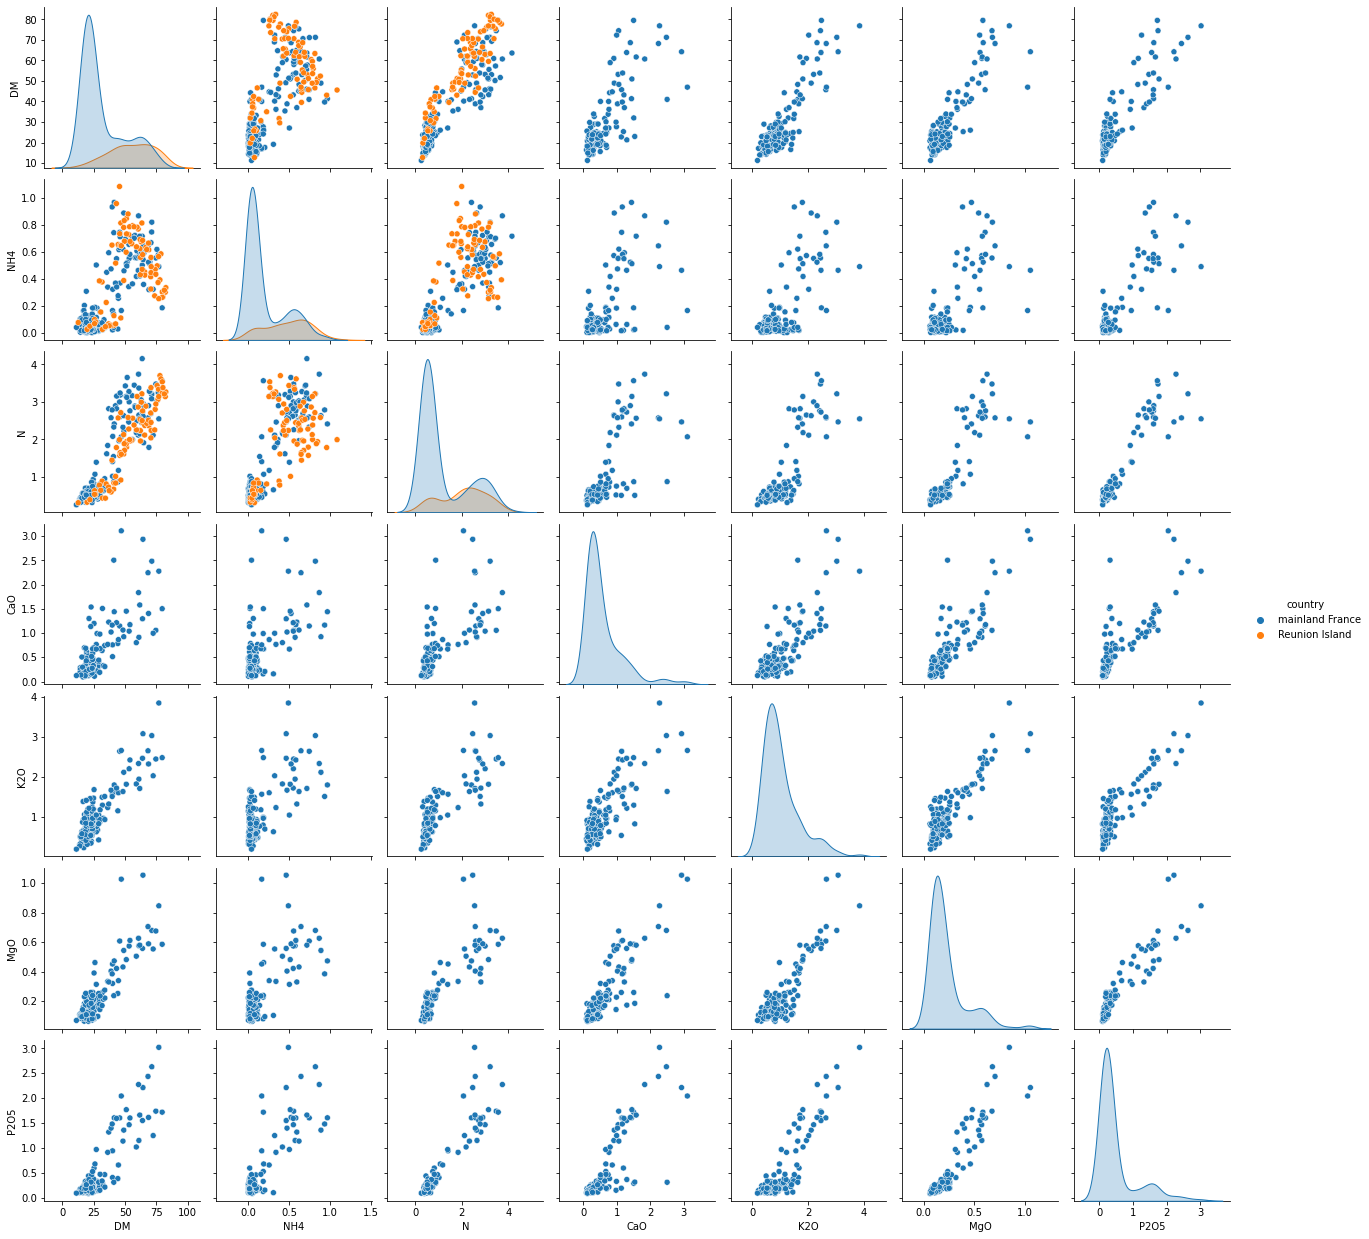

In [17]:
sns.pairplot(df_chemical, diag_kind = "kde", hue = "country")

#### infos graphe précédent
il y a pas toute les données pour les données concernant l'ile de la reunion du coup on mettra un accent sur les données de la France 
Pour simplifier notre étude on va mettre l'accent sur les données provenant de France


## 1-3 conclusion

On va réaliser l'analyse exploratoire en supprimant les données concernant l'iles de la reunion 



## 1-4 analyse exploratoire sans les données chimiques de l'iles de la reunion 


In [18]:
df_chemical_fr = df_chemical.copy()
df_chemical_fr = df_chemical_fr[df_chemical_fr["country"] == "mainland France"]


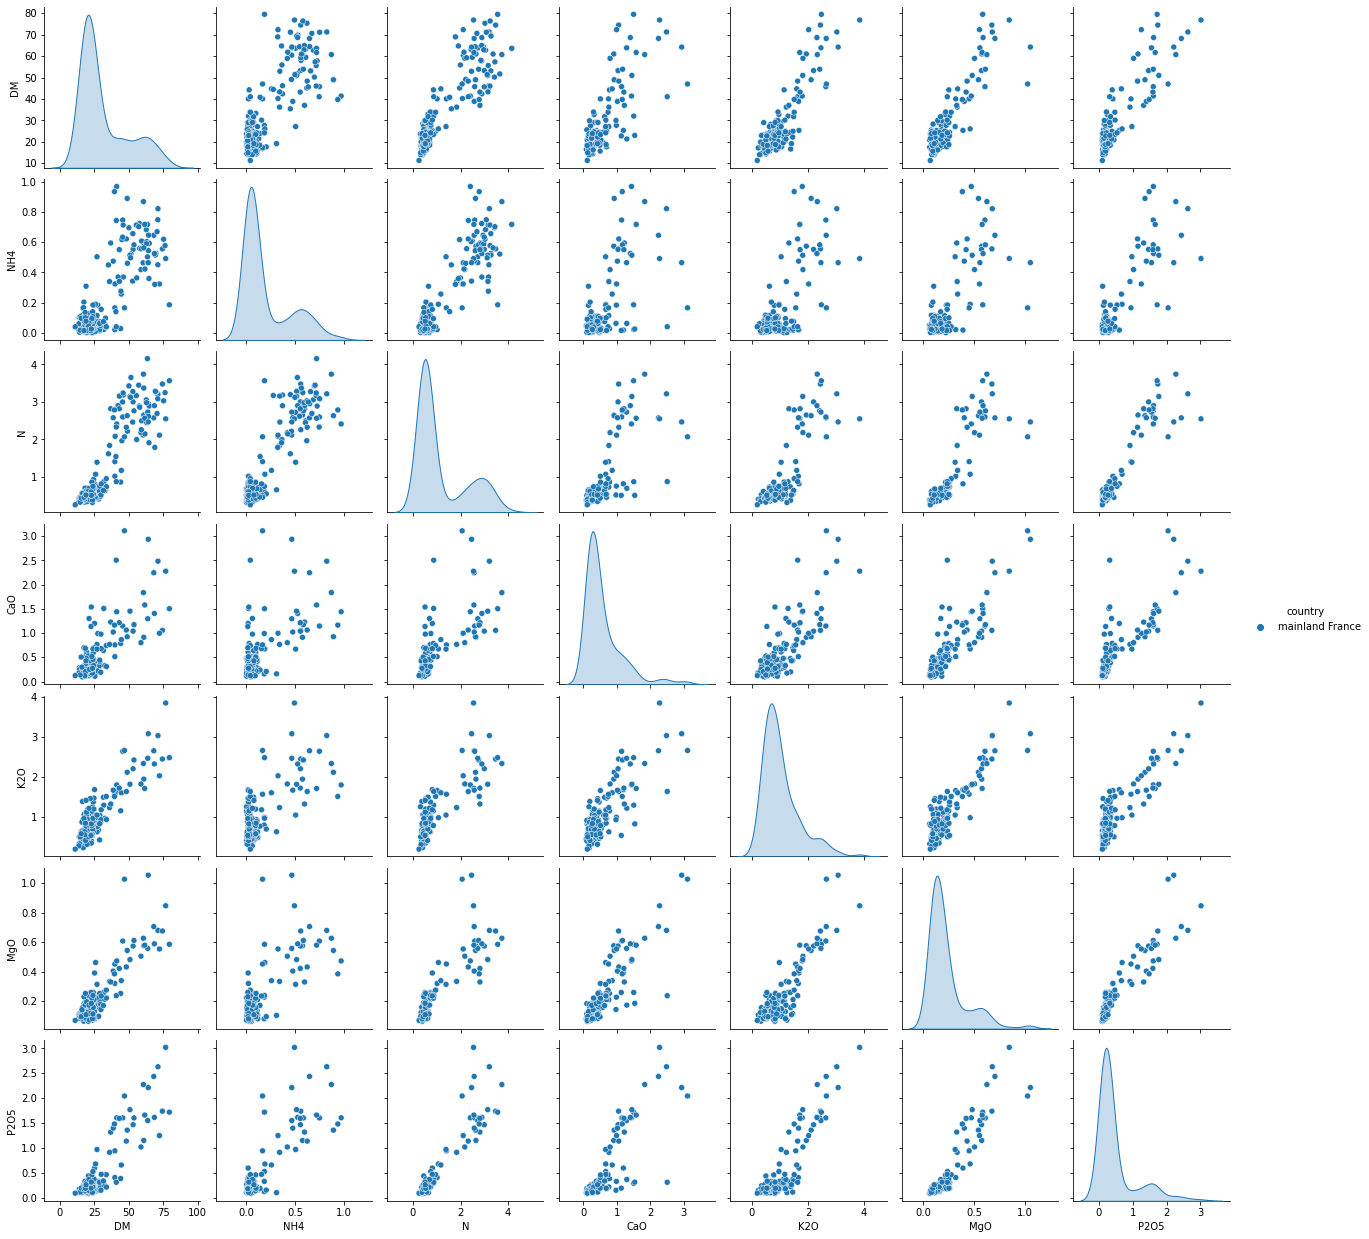

In [19]:
sns.pairplot(df_chemical_fr,diag_kind="kde",hue = "country")

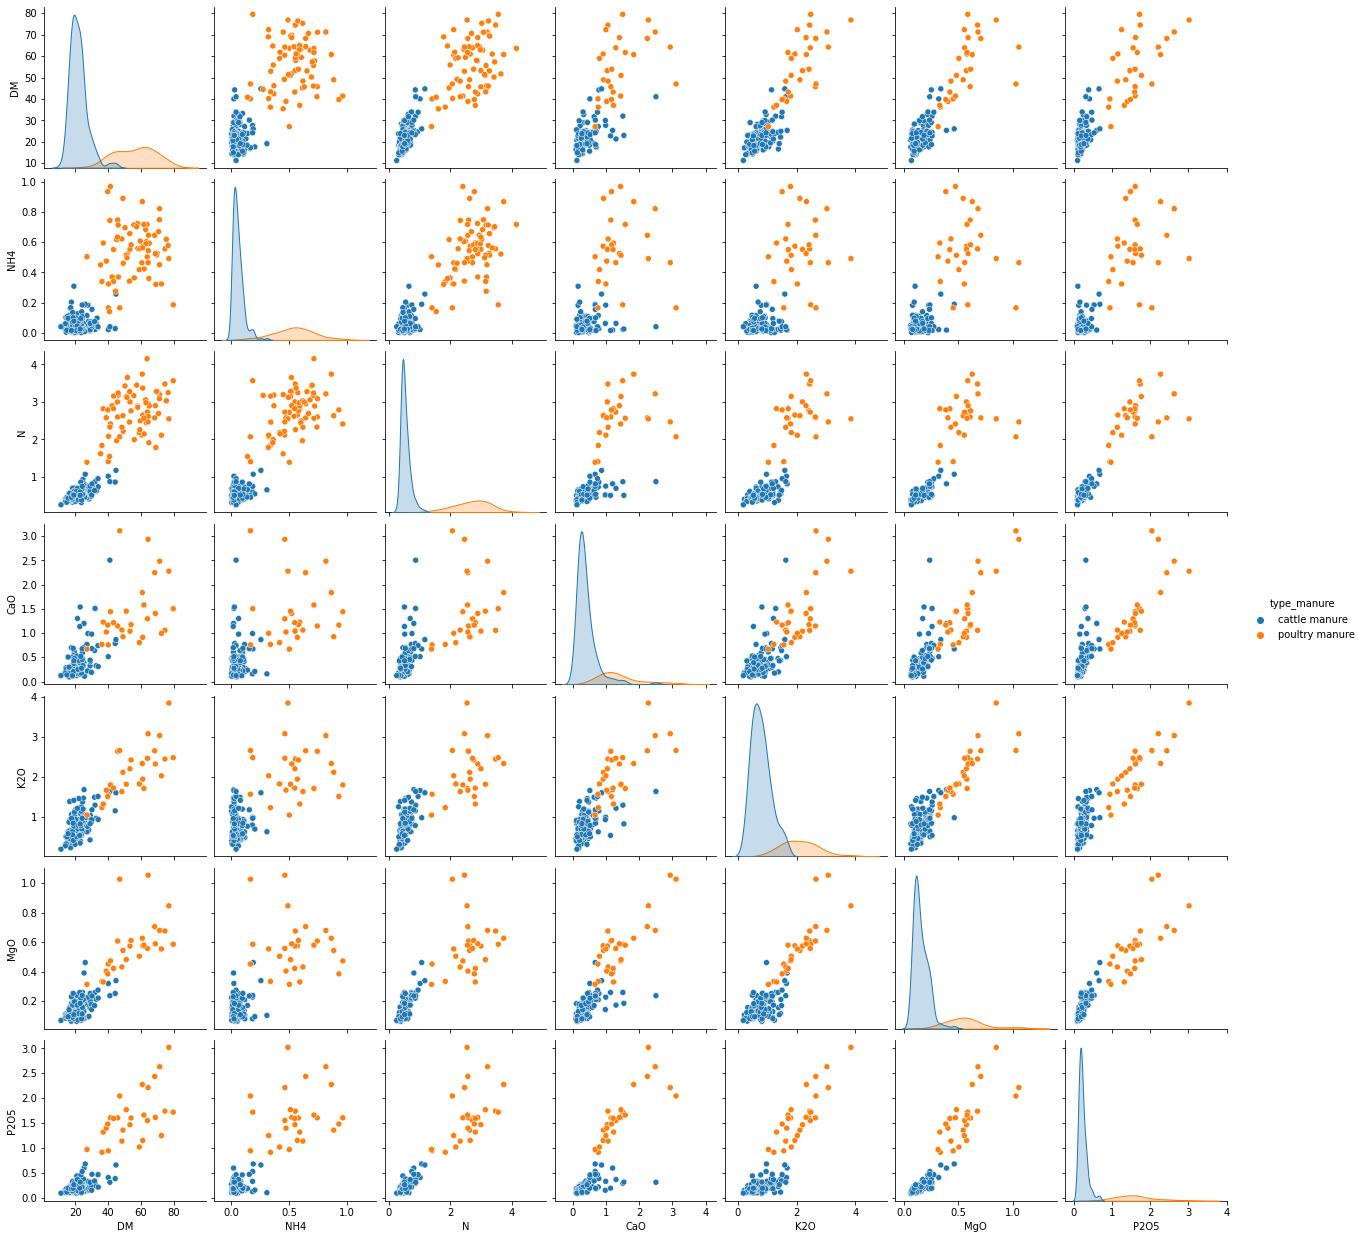

In [20]:
sns.pairplot(df_chemical_fr,diag_kind="kde",hue = "type_manure")

## Conclusion de l'analyse sur le fichiers chemical analysis

Observation:
- le dataset est incomplet
- il existe deux types de variables :
  - variables quantitatives : 7
  - variables qualitatives : 5
- différences des données en fonction 
  - du types de fumiers 
   - faible pour les cattle
   - élévée pour les manure 
- pas de différence significatif en fonction du types de pays : manque de données de la reunion donc suppression

on a toujours une bonne population malgré la suppression des données concernant la france on va par la suite 
se focaliser sur les données spectrales.

## 2- Analyse sur les données spectrales 


il existe deux types de données spectrales les données speectrales sur les fumiers séchés et les fumiers frais

on essaiera de repondre aux question suivantes : 
- existe il une différence significative entre les spectres qui ont été acquis sur différents sites ?
- les spectres permettent elles de différencier les fumiers de manure et de cattle?

### 2-1 spectres de fumiers séchés 

## - les spectres permettent elles de différencier les fumiers de manure et de cattle?

In [21]:
df_spectra_dg = pd.read_excel('data/spectra_DG_Abs_STD_1100_2498nm_STD.xlsx')
df_spectra_dg

,sample_name,1100_nm,1102_nm,1104_nm,1106_nm,1108_nm,1110_nm,1112_nm,1114_nm,1116_nm,...,2480_nm,2482_nm,2484_nm,2486_nm,2488_nm,2490_nm,2492_nm,2494_nm,2496_nm,2498_nm
0,FBCRIF001,0.117115,0.116163,0.115307,0.114564,0.113552,0.112556,0.111460,0.110673,0.110249,...,0.352863,0.354768,0.356484,0.357876,0.359046,0.359973,0.360660,0.361052,0.361174,0.361169
1,FBCRIF002,0.127267,0.126541,0.125739,0.125051,0.124148,0.123225,0.122289,0.121577,0.121105,...,0.362040,0.364098,0.365936,0.367408,0.368604,0.369494,0.370083,0.370328,0.370269,0.370059
2,FBCRIF003,0.146101,0.145503,0.144815,0.144060,0.143048,0.142062,0.140952,0.140115,0.139674,...,0.380576,0.382347,0.383936,0.385200,0.386232,0.387005,0.387527,0.387755,0.387724,0.387581
3,FBCRIF004,0.145878,0.145194,0.144455,0.143708,0.142787,0.141831,0.140752,0.139927,0.139478,...,0.370933,0.372936,0.374728,0.376168,0.377350,0.378252,0.378879,0.379182,0.379185,0.379029
4,FBCRIF005,0.122828,0.122174,0.121568,0.121049,0.120233,0.119437,0.118623,0.117968,0.117673,...,0.361757,0.363635,0.365298,0.366606,0.367655,0.368422,0.368911,0.369075,0.368951,0.368688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,R_FERM_48_FBV_LT,0.537676,0.537457,0.537198,0.536943,0.536700,0.536431,0.536126,0.535814,0.535520,...,0.624336,0.625337,0.626270,0.627058,0.627718,0.628293,0.628763,0.629069,0.629245,0.629400
328,R_FERM_49_FBV_LT,0.692955,0.692954,0.692958,0.692965,0.692965,0.692937,0.692876,0.692799,0.692728,...,0.747222,0.747918,0.748600,0.749176,0.749680,0.750098,0.750421,0.750639,0.750764,0.750878
329,R_FERM_50_FBV_LT,0.688883,0.688761,0.688609,0.688454,0.688296,0.688109,0.687887,0.687651,0.687433,...,0.754622,0.755523,0.756424,0.757197,0.757855,0.758463,0.758965,0.759284,0.759486,0.759662
330,R_FERM_69_FBV,0.262155,0.261556,0.260825,0.260102,0.259437,0.258782,0.258105,0.257412,0.256728,...,0.555208,0.557367,0.559325,0.561040,0.562519,0.563740,0.564675,0.565271,0.565539,0.565593


In [22]:
df_spectra_dg.columns
#len(df_spectra_dg.columns)

Index(['sample_name', '1100_nm', '1102_nm', '1104_nm', '1106_nm', '1108_nm',
       '1110_nm', '1112_nm', '1114_nm', '1116_nm',
       ...
       '2480_nm', '2482_nm', '2484_nm', '2486_nm', '2488_nm', '2490_nm',
       '2492_nm', '2494_nm', '2496_nm', '2498_nm'],
      dtype='object', length=701)

In [23]:
wavenumbers = [str(nombre) for nombre in range(1100, 2499, 2)]

colonnes = ['sample_name']+ wavenumbers
colonnes
#len (colonnes)

['sample_name',
 '1100',
 '1102',
 '1104',
 '1106',
 '1108',
 '1110',
 '1112',
 '1114',
 '1116',
 '1118',
 '1120',
 '1122',
 '1124',
 '1126',
 '1128',
 '1130',
 '1132',
 '1134',
 '1136',
 '1138',
 '1140',
 '1142',
 '1144',
 '1146',
 '1148',
 '1150',
 '1152',
 '1154',
 '1156',
 '1158',
 '1160',
 '1162',
 '1164',
 '1166',
 '1168',
 '1170',
 '1172',
 '1174',
 '1176',
 '1178',
 '1180',
 '1182',
 '1184',
 '1186',
 '1188',
 '1190',
 '1192',
 '1194',
 '1196',
 '1198',
 '1200',
 '1202',
 '1204',
 '1206',
 '1208',
 '1210',
 '1212',
 '1214',
 '1216',
 '1218',
 '1220',
 '1222',
 '1224',
 '1226',
 '1228',
 '1230',
 '1232',
 '1234',
 '1236',
 '1238',
 '1240',
 '1242',
 '1244',
 '1246',
 '1248',
 '1250',
 '1252',
 '1254',
 '1256',
 '1258',
 '1260',
 '1262',
 '1264',
 '1266',
 '1268',
 '1270',
 '1272',
 '1274',
 '1276',
 '1278',
 '1280',
 '1282',
 '1284',
 '1286',
 '1288',
 '1290',
 '1292',
 '1294',
 '1296',
 '1298',
 '1300',
 '1302',
 '1304',
 '1306',
 '1308',
 '1310',
 '1312',
 '1314',
 '1316',
 '1

In [24]:
df_spectra_dg.columns = colonnes

### - création d'un dataset combinant spectre_dg et infos de df_quali

In [25]:
df1 = df_chemical_fr.copy()
df2 = df_spectra_dg.copy()

In [26]:
df_uni_dg = pd.merge(df1,df2).copy()

In [27]:
df_uni_dg.head()

,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5,type_manure,spectrometer,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,FBCRIF001,20.815,0.075,0.490,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,...,0.352863,0.354768,0.356484,0.357876,0.359046,0.359973,0.360660,0.361052,0.361174,0.361169
1,FBCRIF002,25.480,0.182,0.607,0.157,0.791,0.079,0.131,cattle manure,NIRFlex LDAR,...,0.362040,0.364098,0.365936,0.367408,0.368604,0.369494,0.370083,0.370328,0.370269,0.370059
2,FBCRIF003,17.595,0.203,0.546,0.208,0.690,0.094,0.160,cattle manure,NIRFlex LDAR,...,0.380576,0.382347,0.383936,0.385200,0.386232,0.387005,0.387527,0.387755,0.387724,0.387581
3,FBCRIF004,19.110,0.091,0.482,0.260,0.542,0.121,0.187,cattle manure,NIRFlex LDAR,...,0.370933,0.372936,0.374728,0.376168,0.377350,0.378252,0.378879,0.379182,0.379185,0.379029
4,FBCRIF005,18.600,0.089,0.458,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,...,0.361757,0.363635,0.365298,0.366606,0.367655,0.368422,0.368911,0.369075,0.368951,0.368688


In [28]:

df_uni_dg = df_uni_dg.drop(['DM', 'NH4', 'N', 'CaO', 'K2O', 'MgO', 'P2O5'],axis=1)


In [29]:
df_uni_dg.head()

,sample_name,type_manure,spectrometer,township,country,1100,1102,1104,1106,1108,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,FBCRIF001,cattle manure,NIRFlex LDAR,DERVAL,mainland France,0.117115,0.116163,0.115307,0.114564,0.113552,...,0.352863,0.354768,0.356484,0.357876,0.359046,0.359973,0.360660,0.361052,0.361174,0.361169
1,FBCRIF002,cattle manure,NIRFlex LDAR,DERVAL,mainland France,0.127267,0.126541,0.125739,0.125051,0.124148,...,0.362040,0.364098,0.365936,0.367408,0.368604,0.369494,0.370083,0.370328,0.370269,0.370059
2,FBCRIF003,cattle manure,NIRFlex LDAR,DERVAL,mainland France,0.146101,0.145503,0.144815,0.144060,0.143048,...,0.380576,0.382347,0.383936,0.385200,0.386232,0.387005,0.387527,0.387755,0.387724,0.387581
3,FBCRIF004,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France,0.145878,0.145194,0.144455,0.143708,0.142787,...,0.370933,0.372936,0.374728,0.376168,0.377350,0.378252,0.378879,0.379182,0.379185,0.379029
4,FBCRIF005,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France,0.122828,0.122174,0.121568,0.121049,0.120233,...,0.361757,0.363635,0.365298,0.366606,0.367655,0.368422,0.368911,0.369075,0.368951,0.368688


In [30]:
spectra_dg= df_uni_dg.drop(['sample_name', 'type_manure','spectrometer', 'township', 'country'],axis=1).values


#### Visualisation des spectres des fumiers séché

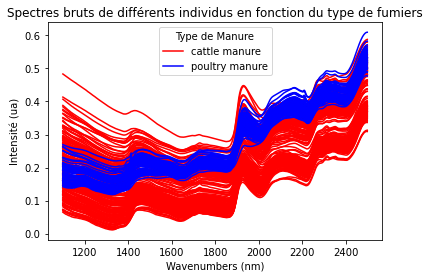

In [41]:

wavenumbers = [nombre for nombre in range(1100, 2499, 2)]
type_manure = df_uni_dg['type_manure'].values
couleurs = { 'cattle manure': 'r', 'poultry manure': 'b'}
# Initialisation d'une liste pour stocker les couleurs correspondantes à chaque type de manure
couleurs_individus = []

# Attribution des couleurs en fonction du type de manure
for nature in type_manure:
    couleur = couleurs.get(nature, 'k')  # 'k' pour noir par défaut
    couleurs_individus.append(couleur)

# Créez un tracé pour chaque individu en utilisant la couleur correspondante
for i in range(len(spectra_dg)):
    plt.plot(wavenumbers, spectra_dg[i], color=couleurs_individus[i], label=type_manure[i])

plt.xlabel('Wavenumbers (nm)')
plt.ylabel('Intensité (ua)')
plt.title('Spectres bruts de différents individus en fonction du type de fumiers')
legend_labels = {'cattle manure': 'red', 'poultry manure': 'blue'}
plt.legend(handles=[plt.Line2D([0], [0], color='red', label='cattle manure'),
                    plt.Line2D([0], [0], color='blue', label='poultry manure')],
           loc='best', title='Type de Manure')
plt.show()

In [78]:
spectra_dg_snv = snv(spectra_dg)

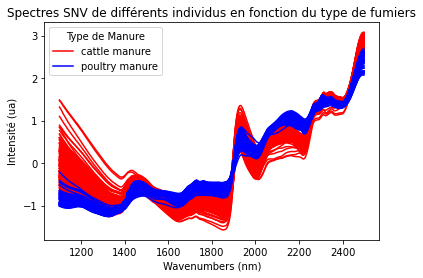

In [79]:
# Initialisation d'une liste pour stocker les couleurs correspondantes à chaque type de manure
couleurs_individus = []

# Attribution des couleurs en fonction du type de manure
for nature in type_manure:
    couleur = couleurs.get(nature, 'k')  # 'k' pour noir par défaut
    couleurs_individus.append(couleur)

# Créez un tracé pour chaque individu en utilisant la couleur correspondante
for i in range(len(spectra_dg)):
    plt.plot(wavenumbers, spectra_dg_snv[i], color=couleurs_individus[i], label=type_manure[i])

plt.xlabel('Wavenumbers (nm)')
plt.ylabel('Intensité (ua)')
plt.title('Spectres SNV de différents individus en fonction du type de fumiers')
legend_labels = {'cattle manure': 'red', 'poultry manure': 'blue'}
plt.legend(handles=[plt.Line2D([0], [0], color='red', label='cattle manure'),
                    plt.Line2D([0], [0], color='blue', label='poultry manure')],
           loc='best', title='Type de Manure')
plt.show()

In [108]:
spectra_dg_msc= msc(spectra_dg)
spectra_dg_msc=spectra_dg_msc[0]


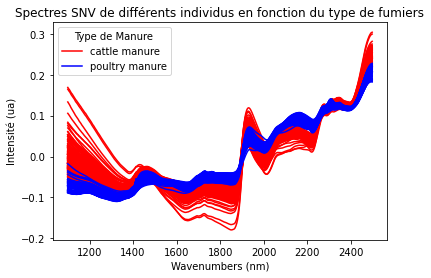

In [110]:
# Initialisation d'une liste pour stocker les couleurs correspondantes à chaque type de manure
couleurs_individus = []

# Attribution des couleurs en fonction du type de manure
for nature in type_manure:
    couleur = couleurs.get(nature, 'k')  # 'k' pour noir par défaut
    couleurs_individus.append(couleur)

# Créez un tracé pour chaque individu en utilisant la couleur correspondante
for i in range(len(spectra_dg)):
    plt.plot(wavenumbers, spectra_dg_msc[i], color=couleurs_individus[i], label=type_manure[i])

plt.xlabel('Wavenumbers (nm)')
plt.ylabel('Intensité (ua)')
plt.title('Spectres SNV de différents individus en fonction du type de fumiers')
legend_labels = {'cattle manure': 'red', 'poultry manure': 'blue'}
plt.legend(handles=[plt.Line2D([0], [0], color='red', label='cattle manure'),
                    plt.Line2D([0], [0], color='blue', label='poultry manure')],
           loc='best', title='Type de Manure')
plt.show()

### Detrend sur les spectres 

In [113]:
spectra_dg_detrended =signal.detrend(spectra_dg, axis=1,  type='linear')

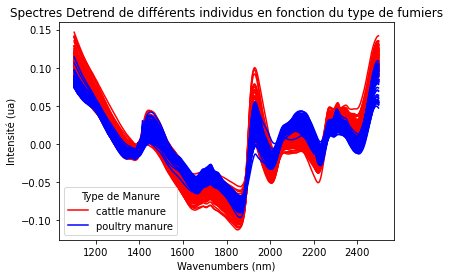

In [114]:
# Initialisation d'une liste pour stocker les couleurs correspondantes à chaque type de manure
couleurs_individus = []

# Attribution des couleurs en fonction du type de manure
for nature in type_manure:
    couleur = couleurs.get(nature, 'k')  # 'k' pour noir par défaut
    couleurs_individus.append(couleur)

# Créez un tracé pour chaque individu en utilisant la couleur correspondante
for i in range(len(spectra_dg)):
    plt.plot(wavenumbers, spectra_dg_detrended[i], color=couleurs_individus[i], label=type_manure[i])

plt.xlabel('Wavenumbers (nm)')
plt.ylabel('Intensité (ua)')
plt.title('Spectres Detrend de différents individus en fonction du type de fumiers')
legend_labels = {'cattle manure': 'red', 'poultry manure': 'blue'}
plt.legend(handles=[plt.Line2D([0], [0], color='red', label='cattle manure'),
                    plt.Line2D([0], [0], color='blue', label='poultry manure')],
           loc='best', title='Type de Manure')
plt.show()

#### réalisons une ACP pour verifier s'il existe une différence entre cattle et poultry manure

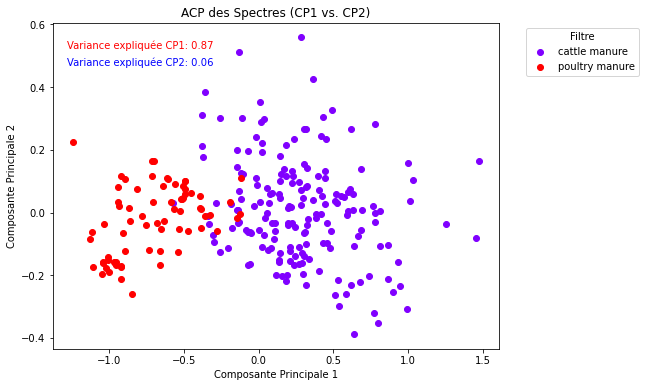

In [115]:
visualisation_acp(spectra_dg, type_manure, numero_composante_axe1 = 0, numero_composante_axe2 = 1)

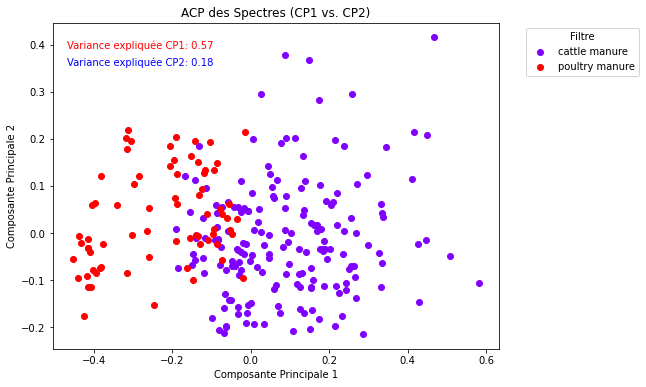

In [116]:
visualisation_acp(spectra_dg_detrended, type_manure, numero_composante_axe1 = 0, numero_composante_axe2 = 1)

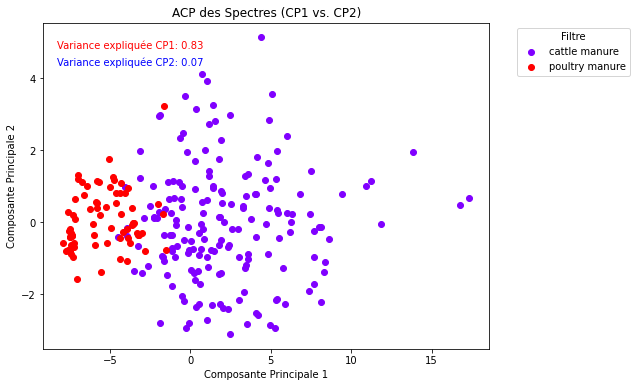

In [117]:
visualisation_acp(spectra_dg_snv, type_manure, numero_composante_axe1 = 0, numero_composante_axe2 = 1)

### petite conclusion sur les spectres ayant subit un Detrend (spectraDG)
On observe une différence entre les différents type de fientes (manure)

### 2-2 Les spectres des manures frais (fresh manure) (spectraFH)


In [50]:
df_spectra_fh = pd.read_excel('data/spectra_FH_Abs_STD_1100_2498nm_STD.xlsx')
df_spectra_fh 

,sample_name,1100_nm,1102_nm,1104_nm,1106_nm,1108_nm,1110_nm,1112_nm,1114_nm,1116_nm,...,2480_nm,2482_nm,2484_nm,2486_nm,2488_nm,2490_nm,2492_nm,2494_nm,2496_nm,2498_nm
0,FBCRIF001,0.588418,0.588407,0.588012,0.587727,0.587602,0.587279,0.586653,0.586186,0.586046,...,1.684603,1.686953,1.689275,1.691759,1.694338,1.696744,1.698854,1.700564,1.701765,1.702570
1,FBCRIF002,0.530671,0.530607,0.530356,0.530160,0.530084,0.529749,0.529146,0.528818,0.528807,...,1.576865,1.579084,1.581248,1.583488,1.585777,1.587941,1.589935,1.591674,1.593029,1.594062
2,FBCRIF003,0.532509,0.532652,0.532556,0.532679,0.532500,0.532282,0.531813,0.531593,0.531658,...,1.610761,1.612479,1.614203,1.616133,1.618259,1.620364,1.622323,1.623984,1.625191,1.626028
3,FBCRIF004,0.495200,0.494887,0.494335,0.493886,0.493594,0.493283,0.492497,0.492086,0.492000,...,1.566656,1.568502,1.570339,1.572338,1.574459,1.576464,1.578253,1.579747,1.580875,1.581749
4,FBCRIF005,0.476230,0.476494,0.476465,0.476356,0.476468,0.476366,0.476144,0.476265,0.476501,...,1.601588,1.603243,1.604913,1.606800,1.608894,1.610958,1.612836,1.614357,1.615386,1.616054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,R_FERM_48_FBV_LT,0.921903,0.921882,0.921879,0.921892,0.921893,0.921852,0.921772,0.921675,0.921602,...,1.521924,1.525306,1.528573,1.531451,1.534228,1.537057,1.539675,1.541941,1.544031,1.546002
328,R_FERM_49_FBV_LT,1.226104,1.226319,1.226631,1.226985,1.227300,1.227568,1.227816,1.228038,1.228266,...,1.557528,1.560118,1.562692,1.565166,1.567635,1.570050,1.572208,1.574032,1.575824,1.577748
329,R_FERM_50_FBV_LT,1.208262,1.208337,1.208493,1.208694,1.208869,1.208999,1.209085,1.209125,1.209165,...,1.782003,1.786263,1.790263,1.793536,1.796581,1.799726,1.802921,1.805966,1.809047,1.812130
330,R_FERM_69_FBV,0.571057,0.570358,0.569508,0.568678,0.567928,0.567190,0.566426,0.565650,0.564924,...,1.547658,1.550831,1.553917,1.556775,1.559369,1.561662,1.563666,1.565651,1.567573,1.569299


In [51]:
df1 = df_chemical_fr.copy()
df2 = df_spectra_fh.copy()
df_uni_fh = pd.merge(df1,df2).copy()
df_uni_fh.head()

,sample_name,DM,NH4,N,CaO,K2O,MgO,P2O5,type_manure,spectrometer,...,2480_nm,2482_nm,2484_nm,2486_nm,2488_nm,2490_nm,2492_nm,2494_nm,2496_nm,2498_nm
0,FBCRIF001,20.815,0.075,0.490,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,...,1.684603,1.686953,1.689275,1.691759,1.694338,1.696744,1.698854,1.700564,1.701765,1.702570
1,FBCRIF002,25.480,0.182,0.607,0.157,0.791,0.079,0.131,cattle manure,NIRFlex LDAR,...,1.576865,1.579084,1.581248,1.583488,1.585777,1.587941,1.589935,1.591674,1.593029,1.594062
2,FBCRIF003,17.595,0.203,0.546,0.208,0.690,0.094,0.160,cattle manure,NIRFlex LDAR,...,1.610761,1.612479,1.614203,1.616133,1.618259,1.620364,1.622323,1.623984,1.625191,1.626028
3,FBCRIF004,19.110,0.091,0.482,0.260,0.542,0.121,0.187,cattle manure,NIRFlex LDAR,...,1.566656,1.568502,1.570339,1.572338,1.574459,1.576464,1.578253,1.579747,1.580875,1.581749
4,FBCRIF005,18.600,0.089,0.458,NaN,NaN,NaN,NaN,cattle manure,NIRFlex LDAR,...,1.601588,1.603243,1.604913,1.606800,1.608894,1.610958,1.612836,1.614357,1.615386,1.616054


In [52]:

df_uni_fh = df_uni_fh.drop(['DM', 'NH4', 'N', 'CaO', 'K2O', 'MgO', 'P2O5'],axis=1)

In [53]:
df_uni_fh.head()

,sample_name,type_manure,spectrometer,township,country,1100_nm,1102_nm,1104_nm,1106_nm,1108_nm,...,2480_nm,2482_nm,2484_nm,2486_nm,2488_nm,2490_nm,2492_nm,2494_nm,2496_nm,2498_nm
0,FBCRIF001,cattle manure,NIRFlex LDAR,DERVAL,mainland France,0.588418,0.588407,0.588012,0.587727,0.587602,...,1.684603,1.686953,1.689275,1.691759,1.694338,1.696744,1.698854,1.700564,1.701765,1.702570
1,FBCRIF002,cattle manure,NIRFlex LDAR,DERVAL,mainland France,0.530671,0.530607,0.530356,0.530160,0.530084,...,1.576865,1.579084,1.581248,1.583488,1.585777,1.587941,1.589935,1.591674,1.593029,1.594062
2,FBCRIF003,cattle manure,NIRFlex LDAR,DERVAL,mainland France,0.532509,0.532652,0.532556,0.532679,0.532500,...,1.610761,1.612479,1.614203,1.616133,1.618259,1.620364,1.622323,1.623984,1.625191,1.626028
3,FBCRIF004,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France,0.495200,0.494887,0.494335,0.493886,0.493594,...,1.566656,1.568502,1.570339,1.572338,1.574459,1.576464,1.578253,1.579747,1.580875,1.581749
4,FBCRIF005,cattle manure,NIRFlex LDAR,CHATEAUNEUF DU FAOU,mainland France,0.476230,0.476494,0.476465,0.476356,0.476468,...,1.601588,1.603243,1.604913,1.606800,1.608894,1.610958,1.612836,1.614357,1.615386,1.616054


In [56]:
spectra_fh= df_uni_fh.drop(['sample_name', 'type_manure','spectrometer', 'township', 'country'],axis=1).values # création d'un array contenant les spectresw

#### Visualisation des spectres des fumiers frais

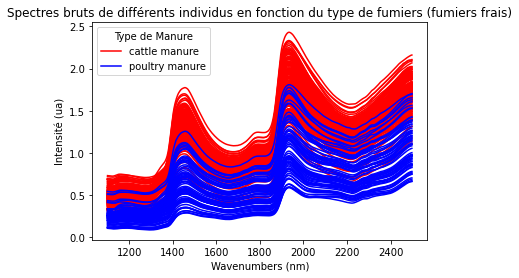

In [58]:

wavenumbers = [nombre for nombre in range(1100, 2499, 2)]
type_manure = df_uni_dg['type_manure'].values
couleurs = { 'cattle manure': 'r', 'poultry manure': 'b'}
# Initialisation d'une liste pour stocker les couleurs correspondantes à chaque type de manure
couleurs_individus = []

# Attribution des couleurs en fonction du type de manure
for nature in type_manure:
    couleur = couleurs.get(nature, 'k')  # 'k' pour noir par défaut
    couleurs_individus.append(couleur)

# Créez un tracé pour chaque individu en utilisant la couleur correspondante
for i in range(len(spectra_fh)):
    plt.plot(wavenumbers, spectra_fh[i], color=couleurs_individus[i], label=type_manure[i])

plt.xlabel('Wavenumbers (nm)')
plt.ylabel('Intensité (ua)')
plt.title('Spectres bruts de différents individus en fonction du type de fumiers (fumiers frais)')
legend_labels = {'cattle manure': 'red', 'poultry manure': 'blue'}
plt.legend(handles=[plt.Line2D([0], [0], color='red', label='cattle manure'),
                    plt.Line2D([0], [0], color='blue', label='poultry manure')],
           loc='best', title='Type de Manure')
plt.show()

On observe un effet additif sur la ligne de base et les spectres aussi de mainère générale (on va donc effectuer une Detrend linéaire)

In [59]:
spectra_fh_detrended =signal.detrend(spectra_fh, axis=1,  type='linear')

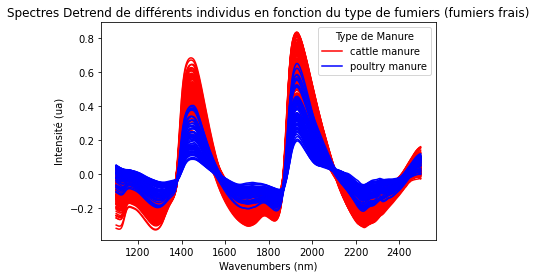

In [60]:

wavenumbers = [nombre for nombre in range(1100, 2499, 2)]
type_manure = df_uni_dg['type_manure'].values
couleurs = { 'cattle manure': 'r', 'poultry manure': 'b'}
# Initialisation d'une liste pour stocker les couleurs correspondantes à chaque type de manure
couleurs_individus = []

# Attribution des couleurs en fonction du type de manure
for nature in type_manure:
    couleur = couleurs.get(nature, 'k')  # 'k' pour noir par défaut
    couleurs_individus.append(couleur)

# Créez un tracé pour chaque individu en utilisant la couleur correspondante
for i in range(len(spectra_fh_detrended)):
    plt.plot(wavenumbers, spectra_fh_detrended[i], color=couleurs_individus[i], label=type_manure[i])

plt.xlabel('Wavenumbers (nm)')
plt.ylabel('Intensité (ua)')
plt.title('Spectres Detrend de différents individus en fonction du type de fumiers (fumiers frais)')
legend_labels = {'cattle manure': 'red', 'poultry manure': 'blue'}
plt.legend(handles=[plt.Line2D([0], [0], color='red', label='cattle manure'),
                    plt.Line2D([0], [0], color='blue', label='poultry manure')],
           loc='best', title='Type de Manure')
plt.show()

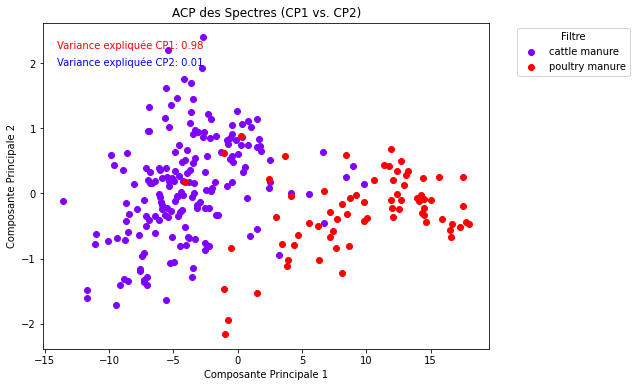

In [61]:
visualisation_acp(spectra_fh, type_manure, numero_composante_axe1 = 0, numero_composante_axe2 = 1)

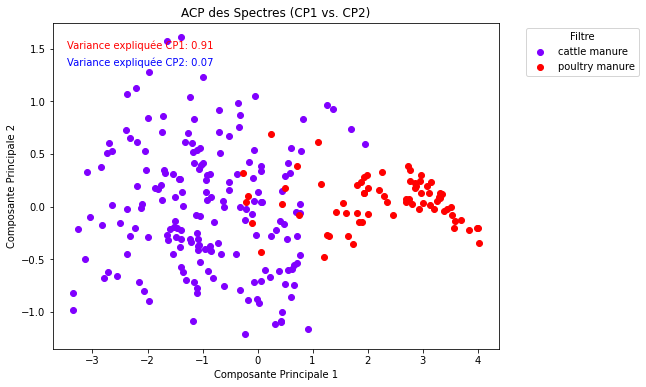

In [62]:
visualisation_acp(spectra_fh_detrended, type_manure, numero_composante_axe1 = 0, numero_composante_axe2 = 1)

### Visualisation des references 